In [1]:
import os
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as Data
torch.manual_seed(8) # for reproduce

import time
import numpy as np
import gc
import sys
sys.setrecursionlimit(50000)
import pickle
torch.backends.cudnn.benchmark = True
torch.set_default_tensor_type('torch.cuda.FloatTensor')
# from tensorboardX import SummaryWriter
torch.nn.Module.dump_patches = True
import copy
import pandas as pd
#then import my own modules
from AttentiveFP import Fingerprint, Fingerprint_viz, save_smiles_dicts, get_smiles_dicts, get_smiles_array, moltosvg_highlight

RDKit WARNING: [01:49:38] Enabling RDKit 2019.09.3 jupyter extensions
[01:49:38] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
from rdkit import Chem
# from rdkit.Chem import AllChem
from rdkit.Chem import QED
from rdkit.Chem import rdMolDescriptors, MolSurf
from rdkit.Chem.Draw import SimilarityMaps
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
%matplotlib inline
from numpy.polynomial.polynomial import polyfit
import matplotlib.pyplot as plt
from matplotlib import gridspec
import matplotlib.cm as cm
import matplotlib
import seaborn as sns; sns.set_style("darkgrid")
from IPython.display import SVG, display
import sascorer
import itertools
from sklearn.metrics import r2_score
import scipy

In [3]:
random_seed = 888 # 69, 88
start_time = str(time.ctime()).replace(':','-').replace(' ','_')

batch_size = 200
epochs = 200

p_dropout= 0.2
fingerprint_dim = 200

weight_decay = 5 # also known as l2_regularization_lambda
learning_rate = 2.5
output_units_num = 1 # for regression model
radius = 2
T = 4

number of all smiles:  4200


number of successfully processed smiles:  4200


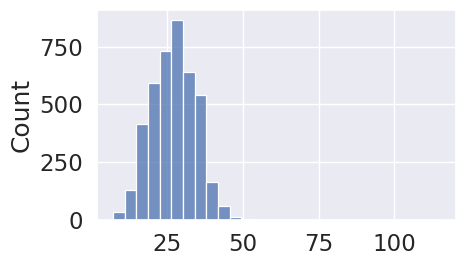

In [4]:
task_name = 'lipophilicity'
tasks = ['exp']

raw_filename = "../data/Lipophilicity.csv"
feature_filename = raw_filename.replace('.csv','.pickle')
filename = raw_filename.replace('.csv','')
prefix_filename = raw_filename.split('/')[-1].replace('.csv','')
smiles_tasks_df = pd.read_csv(raw_filename)
smilesList = smiles_tasks_df.smiles.values
print("number of all smiles: ",len(smilesList))
atom_num_dist = []
remained_smiles = []
canonical_smiles_list = []
for smiles in smilesList:
    try:        
        mol = Chem.MolFromSmiles(smiles)
        atom_num_dist.append(len(mol.GetAtoms()))
        remained_smiles.append(smiles)
        canonical_smiles_list.append(Chem.MolToSmiles(Chem.MolFromSmiles(smiles), isomericSmiles=True))
    except:
        print(smiles)
        pass
print("number of successfully processed smiles: ", len(remained_smiles))
smiles_tasks_df = smiles_tasks_df[smiles_tasks_df["smiles"].isin(remained_smiles)]
# print(smiles_tasks_df)
smiles_tasks_df['cano_smiles'] =canonical_smiles_list
assert canonical_smiles_list[8]==Chem.MolToSmiles(Chem.MolFromSmiles(smiles_tasks_df['cano_smiles'][8]), isomericSmiles=True)

plt.figure(figsize=(5, 3))
sns.set(font_scale=1.5)
ax = sns.histplot(atom_num_dist, bins=28, kde=False)
plt.tight_layout()
# plt.savefig("atom_num_dist_"+prefix_filename+".png",dpi=200)
plt.show()
plt.close()


In [5]:
if os.path.isfile(feature_filename):
    feature_dicts = pickle.load(open(feature_filename, "rb" ))
else:
    feature_dicts = save_smiles_dicts(smilesList,filename)
# feature_dicts = get_smiles_dicts(smilesList)
remained_df = smiles_tasks_df[smiles_tasks_df["cano_smiles"].isin(feature_dicts['smiles_to_atom_mask'].keys())]
uncovered_df = smiles_tasks_df.drop(remained_df.index)
print("not processed items")
uncovered_df

feature dicts file saved as ../data/Lipophilicity.pickle
not processed items


,CMPD_CHEMBLID,exp,smiles,cano_smiles


In [6]:
remained_df = remained_df.reset_index(drop=True)
test_df = remained_df.sample(frac=1/10, random_state=random_seed) # test set
training_data = remained_df.drop(test_df.index) # training data

# training data is further divided into validation set and train set
valid_df = training_data.sample(frac=1/9, random_state=random_seed) # validation set
train_df = training_data.drop(valid_df.index) # train set
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

# print(len(test_df),sorted(test_df.cano_smiles.values))


In [7]:
x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array([canonical_smiles_list[0]],feature_dicts)
num_atom_features = x_atom.shape[-1]
num_bond_features = x_bonds.shape[-1]
loss_function = nn.MSELoss()
model = Fingerprint(radius, T, num_atom_features, num_bond_features,
            fingerprint_dim, output_units_num, p_dropout)
model.cuda()

# optimizer = optim.Adam(model.parameters(), learning_rate, weight_decay=weight_decay)
optimizer = optim.Adam(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)
# optimizer = optim.SGD(model.parameters(), 10**-learning_rate, weight_decay=10**-weight_decay)

# tensorboard = SummaryWriter(log_dir="runs/"+start_time+"_"+prefix_filename+"_"+str(fingerprint_dim)+"_"+str(p_dropout))

model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data.shape)
        

863604
atom_fc.weight torch.Size([200, 39])
atom_fc.bias torch.Size([200])
neighbor_fc.weight torch.Size([200, 49])
neighbor_fc.bias torch.Size([200])
GRUCell.0.weight_ih torch.Size([600, 200])
GRUCell.0.weight_hh torch.Size([600, 200])
GRUCell.0.bias_ih torch.Size([600])
GRUCell.0.bias_hh torch.Size([600])
GRUCell.1.weight_ih torch.Size([600, 200])
GRUCell.1.weight_hh torch.Size([600, 200])
GRUCell.1.bias_ih torch.Size([600])
GRUCell.1.bias_hh torch.Size([600])
align.0.weight torch.Size([1, 400])
align.0.bias torch.Size([1])
align.1.weight torch.Size([1, 400])
align.1.bias torch.Size([1])
attend.0.weight torch.Size([200, 200])
attend.0.bias torch.Size([200])
attend.1.weight torch.Size([200, 200])
attend.1.bias torch.Size([200])
mol_GRUCell.weight_ih torch.Size([600, 200])
mol_GRUCell.weight_hh torch.Size([600, 200])
mol_GRUCell.bias_ih torch.Size([600])
mol_GRUCell.bias_hh torch.Size([600])
mol_align.weight torch.Size([1, 400])
mol_align.bias torch.Size([1])
mol_attend.weight torch.Si

In [8]:
def train(model, dataset, optimizer, loss_function):
    model.train()
    np.random.seed(epoch)
    valList = np.arange(0,dataset.shape[0])
    #shuffle them
    np.random.shuffle(valList)
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch)   
    for counter, train_batch in enumerate(batch_list):
        batch_df = dataset.loc[train_batch,:]
        smiles_list = batch_df.cano_smiles.values
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        
        model.zero_grad()
        loss = loss_function(mol_prediction, torch.Tensor(y_val).view(-1,1))     
        loss.backward()
        optimizer.step()
def eval(model, dataset):
    model.eval()
    eval_MAE_list = []
    eval_MSE_list = []
    valList = np.arange(0,dataset.shape[0])
    batch_list = []
    for i in range(0, dataset.shape[0], batch_size):
        batch = valList[i:i+batch_size]
        batch_list.append(batch) 
    for counter, eval_batch in enumerate(batch_list):
        batch_df = dataset.loc[eval_batch,:]
        smiles_list = batch_df.cano_smiles.values
#         print(batch_df)
        y_val = batch_df[tasks[0]].values
        
        x_atom, x_bonds, x_atom_index, x_bond_index, x_mask, smiles_to_rdkit_list = get_smiles_array(smiles_list,feature_dicts)
        atoms_prediction, mol_prediction = model(torch.Tensor(x_atom),torch.Tensor(x_bonds),torch.cuda.LongTensor(x_atom_index),torch.cuda.LongTensor(x_bond_index),torch.Tensor(x_mask))
        MAE = F.l1_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')        
        MSE = F.mse_loss(mol_prediction, torch.Tensor(y_val).view(-1,1), reduction='none')
#         print(x_mask[:2],atoms_prediction.shape, mol_prediction,MSE)
        
        eval_MAE_list.extend(MAE.data.squeeze().cpu().numpy())
        eval_MSE_list.extend(MSE.data.squeeze().cpu().numpy())
    return np.array(eval_MAE_list).mean(), np.array(eval_MSE_list).mean()


In [9]:
best_param ={}
best_param["train_epoch"] = 0
best_param["valid_epoch"] = 0
best_param["train_MSE"] = 9e8
best_param["valid_MSE"] = 9e8

for epoch in range(800):
    train_MAE, train_MSE = eval(model, train_df)
    valid_MAE, valid_MSE = eval(model, valid_df)
#     tensorboard.add_scalars('MAE',{'train_MAE':valid_MAE, 'test_MAE':valid_MSE}, epoch)
#     tensorboard.add_scalars('MSE',{'train_MSE':valid_MAE, 'test_MSE':valid_MSE}, epoch)
    if train_MSE < best_param["train_MSE"]:
        best_param["train_epoch"] = epoch
        best_param["train_MSE"] = train_MSE
    if valid_MSE < best_param["valid_MSE"]:
        best_param["valid_epoch"] = epoch
        best_param["valid_MSE"] = valid_MSE
        if valid_MSE < 0.40:
             torch.save(model.state_dict(), 'saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(epoch)+'.pt')
    if (epoch - best_param["train_epoch"] >8) and (epoch - best_param["valid_epoch"] >18):        
        break
    print(epoch, np.sqrt(train_MSE), np.sqrt(valid_MSE))
    
    train(model, train_df, optimizer, loss_function)


0 2.4798949 2.4575636


1 1.1533258 1.1915908


2 1.1203685 1.1392236


3 1.0459511 1.053


4 1.0572181 1.0791514


5 1.0025965 0.9701235


6 0.9699439 0.96334255


7 0.9047249 0.877962


8 0.88397133 0.85771495


9 0.85330445 0.83512646


10 0.7673558 0.7710784


11 0.86640704 0.87711096


12 0.80561715 0.83763975


13 0.72693557 0.734392


14 0.7266733 0.75959307


15 0.6821671 0.7150554


16 0.7665107 0.8168383


17 0.7909977 0.821832


18 0.66778237 0.70676273


19 0.63949865 0.6890933


20 0.61827856 0.6748792


21 0.6056525 0.6459349


22 0.61405486 0.6721719


23 0.5793843 0.6441926


24 0.56275016 0.6370893


25 0.5582124 0.62741065


26 0.5462408 0.6275221


27 0.5541185 0.6503258


28 0.5439291 0.64074427


29 0.5159447 0.62186235


30 0.5830717 0.6663702


31 0.52590704 0.6449821


32 0.5061806 0.6228238


33 0.5244844 0.61954916


34 0.48783395 0.6171214


35 0.4942812 0.6289846


36 0.48344994 0.6174598


37 0.46630433 0.6112322


38 0.46298623 0.591416


39 0.5120076 0.6572045


40 0.5125961 0.6557898


41 0.43948817 0.6078698


42 0.4501165 0.59946746


43 0.45132172 0.5934511


44 0.43971002 0.6122407


45 0.45672747 0.6212578


46 0.4402771 0.60929215


47 0.4089258 0.6228982


48 0.43113726 0.6003905


49 0.41955522 0.5996426


50 0.3962534 0.58962315


51 0.4026918 0.5827215


52 0.37833598 0.60365903


53 0.40402296 0.6214055


54 0.36831632 0.59465003


55 0.37479958 0.60846066


56 0.37691954 0.6173871


57 0.37671605 0.60769624


58 0.3444807 0.6093701


59 0.33223444 0.60321337


60 0.37331325 0.61439854


61 0.32967144 0.5927101


62 0.32145995 0.6032347


63 0.3140301 0.58937436


64 0.36295387 0.6228251


65 0.3152711 0.5831416


66 0.32261264 0.6051288


67 0.30005214 0.60496885


68 0.33828926 0.60756135


69 0.29626346 0.58899975


70 0.29844087 0.5970205


71 0.292426 0.5889359


72 0.32825565 0.59903795


73 0.31321344 0.62621


74 0.27438545 0.60157657


75 0.26719174 0.6028401


76 0.26654288 0.5985041


77 0.25495028 0.5882052


78 0.24919209 0.5900111


79 0.25116867 0.58494055


80 0.25118482 0.5754572


81 0.24711952 0.5862012


82 0.25100037 0.5888789


83 0.23849554 0.58228505


84 0.24563114 0.5999697


85 0.24841344 0.5978534


86 0.27788725 0.6212921


87 0.24012259 0.593499


88 0.22834404 0.6004752


89 0.22047292 0.6048344


90 0.23685975 0.5924555


91 0.23223063 0.5939331


92 0.20789078 0.5914027


93 0.20725395 0.59325093


94 0.21281828 0.5818219


95 0.20931704 0.5904797


96 0.22583272 0.59389484


97 0.22008118 0.59573525


98 0.21348964 0.5941309


99 0.20830719 0.6020882


100 0.20697616 0.6049457


101 0.18412323 0.5999177


102 0.18830092 0.60302263


103 0.19484693 0.60082865


104 0.1936571 0.5908131


105 0.18186505 0.59225506


106 0.18913588 0.5915552


107 0.21868289 0.60819316


108 0.24315137 0.6062843


109 0.18819635 0.59703076


110 0.17905591 0.59810555


111 0.19528234 0.6171447


112 0.2022509 0.6040434


113 0.2023264 0.5982528


114 0.17854586 0.6106682


115 0.17234193 0.58760715


116 0.16658181 0.59333235


117 0.16329089 0.5977319


118 0.16518292 0.6071327


119 0.16498683 0.59872097


120 0.14998603 0.60400546


121 0.16739106 0.61495


122 0.16373979 0.6017005


123 0.17912987 0.6020545


124 0.17797996 0.6158598


125 0.22746374 0.6222865


126 0.18357262 0.6132588


127 0.16300951 0.5882358


128 0.20109707 0.62446743


In [10]:
# evaluate model
best_model = Fingerprint(radius, T, num_atom_features, num_bond_features, fingerprint_dim, output_units_num, p_dropout)
best_model_state_dict = torch.load('saved_models/model_'+prefix_filename+'_'+start_time+'_'+str(best_param["valid_epoch"])+'.pt')
best_model.load_state_dict(best_model_state_dict)     
best_model.cuda()

best_model_dict = best_model.state_dict()
best_model_wts = copy.deepcopy(best_model_dict)

model.load_state_dict(best_model_wts)
(best_model.align[0].weight == model.align[0].weight).all()
test_MAE, test_MSE = eval(model, test_df)
print("best epoch:",best_param["valid_epoch"],"\n","test RMSE:",np.sqrt(test_MSE))

best epoch: 80 
 test RMSE: 0.6005963
